In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from tensorflow import keras

In [2]:
df = pd.read_csv("../dataset/preprocessed_data.csv")
df

user_id  recipe_id        date  rating   
0          7708      60599  2005-09-02       4  \
1         27707      60599  2005-12-22       5   
2         35308      60599  2006-09-26       5   
3         19399      60599  2007-03-09       5   
4         43887      60599  2008-02-20       0   
...         ...        ...         ...     ...   
942363    10188      22092  2007-04-26       0   
942364    51769     161871  2009-09-29       5   
942365    15786      33054  2008-06-23       5   
942366     5051      33054  2009-01-11       4   
942367   181745      33054  2017-12-18       5   

                                                   review   
0                                               very good  \
1                                    better than the real   
2       absolutely awesome i was speechless when i tri...   
3       these taste absolutely wonderful my son in law...   
4       made my own buttermilk w vinegar and milk. use...   
...                                                   ...   
942363  i am not going to rate this because i did have...   
942364  these were so delicious my husband and i truly...   
942365  wow sometimes i do not take the time to rate r...   
942366  very good i used regular port as well. the gra...   
942367  i am so glad i googled and found this here. th...   

                                   name  minutes  contributor_id   submitted   
0                  kfc honey bbq strips       40          166019  2005-08-24  \
1                  kfc honey bbq strips       40          166019  2005-08-24   
2                  kfc honey bbq strips       40          166019  2005-08-24   
3                  kfc honey bbq strips       40          166019  2005-08-24   
4                  kfc honey bbq strips       40          166019  2005-08-24   
...                                 ...      ...             ...         ...   
942363             garlic clove chicken       65           49304  2003-02-21   
942364  stacey e s yummy veggie burgers       21          742029  2009-08-24   
942365    pot roast with port stove top      115          108291  2003-12-05   
942366    pot roast with port stove top      115          108291  2003-12-05   
942367    pot roast with port stove top      115          108291  2003-12-05   

                                                     tags  ...  sugar sodium   
0       60-minutes-or-less, time-to-make, main-ingredi...  ...   40.0   37.0  \
1       60-minutes-or-less, time-to-make, main-ingredi...  ...   40.0   37.0   
2       60-minutes-or-less, time-to-make, main-ingredi...  ...   40.0   37.0   
3       60-minutes-or-less, time-to-make, main-ingredi...  ...   40.0   37.0   
4       60-minutes-or-less, time-to-make, main-ingredi...  ...   40.0   37.0   
...                                                   ...  ...    ...    ...   
942363  weeknight, time-to-make, course, main-ingredie...  ...    1.0    7.0   
942364  30-minutes-or-less, time-to-make, course, main...  ...   11.0   24.0   
942365  weeknight, time-to-make, course, preparation, ...  ...   22.0   20.0   
942366  weeknight, time-to-make, course, preparation, ...  ...   22.0   20.0   
942367  weeknight, time-to-make, course, preparation, ...  ...   22.0   20.0   

       protein saturated_fat  carbohydrates  food_types  negative  neutral   
0         78.0           4.0           10.0     Non-veg     0.000    0.238  \
1         78.0           4.0           10.0     Non-veg     0.000    0.508   
2         78.0           4.0           10.0     Non-veg     0.000    0.883   
3         78.0           4.0           10.0     Non-veg     0.000    0.675   
4         78.0           4.0           10.0     Non-veg     0.000    0.929   
...        ...           ...            ...         ...       ...      ...   
942363    53.0          29.0            2.0     Non-veg     0.071    0.929   
942364    10.0           0.0            8.0     Healthy     0.000    0.752   
942365    93.0         112.0            4.0       

In [3]:
df = df.sample(frac=1, random_state=42)

user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
recipe_ids = df["recipe_id"].unique().tolist()
recipe2recipe_encoded = {x: i for i, x in enumerate(recipe_ids)}
recipe_encoded2recipe = {i: x for i, x in enumerate(recipe_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["recipe"] = df["recipe_id"].map(recipe2recipe_encoded)

num_users = len(user2user_encoded)
num_recipes = len(recipe_encoded2recipe)
df["rating"] = df["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Recipes: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_recipes, min_rating, max_rating
    )
)

Number of users: 192751, Number of Recipes: 194084, Min rating: 0.0, Max rating: 5.0


In [4]:
x = df[["user", "recipe"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"] / 5
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [5]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Metal device set to: Apple M1 Pro
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

EMBEDDING_SIZE = 16


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_recipes, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_recipes = num_recipes
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-1),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.recipe_embedding = layers.Embedding(
            num_recipes,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-1),
        )
        self.recipe_bias = layers.Embedding(num_recipes, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        recipe_vector = self.recipe_embedding(inputs[:, 1])
        recipe_bias = self.recipe_bias(inputs[:, 1])
        dot_user_recipe = tf.tensordot(user_vector, recipe_vector, 2)
        # Add all the components (including bias)
        x = dot_user_recipe + user_bias + recipe_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


# with strategy.scope():
model = RecommenderNet(num_users, num_recipes, EMBEDDING_SIZE)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-8, verbose=1)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error', metrics=['mse']
)

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[reduce_lr_on_plateau, early_stopping]
)

Epoch 1/50


2023-04-30 19:19:54.828934: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


737/737 [==============================] - 23s 30ms/step - loss: 0.2140 - mse: 0.1817 - val_loss: 0.1569 - val_mse: 0.1569 - lr: 0.0010
Epoch 2/50
737/737 [==============================] - 20s 27ms/step - loss: 0.1376 - mse: 0.1376 - val_loss: 0.1250 - val_mse: 0.1249 - lr: 0.0010
Epoch 3/50
737/737 [==============================] - 20s 27ms/step - loss: 0.1109 - mse: 0.1108 - val_loss: 0.1059 - val_mse: 0.1057 - lr: 0.0010
Epoch 4/50
737/737 [==============================] - 20s 27ms/step - loss: 0.0941 - mse: 0.0939 - val_loss: 0.0936 - val_mse: 0.0934 - lr: 0.0010
Epoch 5/50
737/737 [==============================] - 20s 27ms/step - loss: 0.0828 - mse: 0.0825 - val_loss: 0.0854 - val_mse: 0.0851 - lr: 0.0010
Epoch 6/50
737/737 [==============================] - 20s 27ms/step - loss: 0.0746 - mse: 0.0743 - val_loss: 0.0796 - val_mse: 0.0793 - lr: 0.0010
Epoch 7/50
737/737 [==============================] - 20s 27ms/step - loss: 0.0685 - mse: 0.0682 - val_loss: 0.0753 - val_mse: 0.

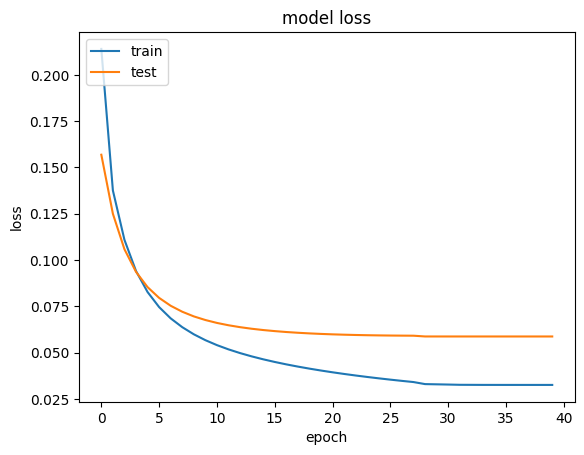

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [50]:
y_pred = model.predict(x_val)

5890/5890 [==============================] - 53s 9ms/step


In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_val * 5, y_pred.flatten() * 5))
print(rms)

1.2121630465899584


In [52]:
model.save("../models/recommendation")

INFO:tensorflow:Assets written to: ../models/recommendation/assets


INFO:tensorflow:Assets written to: ../models/recommendation/assets


In [53]:
# save recipe2recipe_encoded to json
import json

with open('../models/recommendation/recipe2recipe_encoded.json', 'w') as fp:
    json.dump(recipe2recipe_encoded, fp)
with open('../models/recommendation/user2user_encoded.json', 'w') as fp:
    json.dump(user2user_encoded, fp)
with open('../models/recommendation/recipe_encoded2recipe.json', 'w') as fp:
    json.dump(recipe_encoded2recipe, fp)
with open('../models/recommendation/user_encoded2user.json', 'w') as fp:
    json.dump(userencoded2user, fp)

In [54]:
!zip -r model.zip ../models/recommendation

updating: ../models/recommendation/ (stored 0%)
updating: ../models/recommendation/fingerprint.pb (stored 0%)
updating: ../models/recommendation/user2user_encoded.json (deflated 66%)
updating: ../models/recommendation/keras_metadata.pb (deflated 82%)
updating: ../models/recommendation/recipe_encoded2recipe.json (deflated 66%)
updating: ../models/recommendation/variables/ (stored 0%)
updating: ../models/recommendation/variables/variables.data-00000-of-00001 (deflated 13%)
updating: ../models/recommendation/variables/variables.index (deflated 40%)
updating: ../models/recommendation/user_encoded2user.json (deflated 66%)
updating: ../models/recommendation/saved_model.pb (deflated 88%)
updating: ../models/recommendation/assets/ (stored 0%)
updating: ../models/recommendation/recipe2recipe_encoded.json (deflated 66%)


In [55]:
recipe_encoded2recipe[0]

19815

In [56]:
recipe2recipe_encoded[60599]

51562

In [57]:
df

user_id  recipe_id        date  rating   
120542    43170      19815  2008-12-03     5.0  \
13189     20393      51000  2005-06-28     5.0   
552040   176514      26255  2017-07-22     5.0   
657357     3016     150492  2009-02-26     5.0   
20918     39878      50480  2007-11-24     5.0   
...         ...        ...         ...     ...   
259178    49737     123061  2008-05-31     5.0   
365838    58954     157244  2009-05-20     5.0   
131932    42140     143082  2008-10-28     5.0   
671155    53876      10277  2008-05-20     5.0   
121958    68584     170312  2011-09-19     5.0   

                                                   review   
120542  absolutely delicious i had no idea what chines...  \
13189   oh wow this is good sweet in your mouth and a ...   
552040  used this to make waffle bowl. it is great for...   
657357  this was nice with the lime i did not have any...   
20918   very nice. my first time baking rolls from my ...   
...                                                   ...   
259178  these were very tasty. i do not do spicy very ...   
365838  i like the carmelized flavor that roasting giv...   
131932  i made this for my husband for our first weddi...   
671155  these were good the first day.but the next day...   
121958  we all loved this bread based on earlier revie...   

                                              name  minutes  contributor_id   
120542                  purple cabbage pecan salad        5           57479  \
13189                          strawberry lemonade       20          195916   
552040                    the best belgian waffles       40           24386   
657357                  pomegranate julep mocktail        5          187927   
20918     sweet buttery rolls bread machine recipe       30          200115   
...                                            ...      ...             ...   
259178  thai chicken cakes with sweet chilli sauce       15          527607   
365838                         roasted celery root       70          866838   
131932                                asiago pasta       35          656643   
671155             oven fried chicken chimichangas       45            6258   
121958                 orange chocolate chip bread       80          424680   

         submitted                                               tags  ...   
120542  2002-12-22  15-minutes-or-less, time-to-make, course, main...  ...  \
13189   2005-03-24  30-minutes-or-less, time-to-make, course, prep...  ...   
552040  2003-05-27  60-minutes-or-less, time-to-make, course, prep...  ...   
657357  2009-02-04  15-minutes-or-less, time-to-make, course, prep...  ...   
20918   2005-03-10  30-minutes-or-less, time-to-make, course, prep...  ...   
...            ...                                                ...  ...   
259178  2008-01-21  15-minutes-or-less, time-to-make, course, main...  ...   
365838  2009-05-20  time-to-make, course, main-ingredient, prepara...  ...   
131932  2008-10-21  60-minutes-or-less, time-to-make, course, main...  ...   
671155  2002-05-13  60-minutes-or-less, time-to-make, course, main...  ...   
121958  2010-03-03  time-to-make, course, main-ingredient, prepara...  ...   

        protein saturated_fat carbohydrates   food_types  negative  neutral   
120542      7.0           8.0           7.0      Healthy     0.049    0.749  \
13189       1.0           0.0          18.0      Healthy     0.000    0.501   
552040     27.0          35.0          22.0      Non-veg     0.000    0.907   
657357      0.0           0.0           1.0      Healthy     0.051    0.671   
20918       9.0          21.0           9.0      Healthy     0.000    0.591   
...         ...           ...           ...          ...       ...      ...   
259178     31.0          14.0           0.0      Healthy     0.000    0.720   
365838      9.0           9.0           9.0      Healthy     0.025    0.854   
131932     16.0         116.0          21.0      Non-veg     0.000    0.671  

In [58]:
model = keras.models.load_model('../models/recommendation')

In [59]:
user_embedding = model.user_embedding.get_weights()[0]
user_embedding.shape

(192751, 16)

In [60]:
recipe_embedding = model.recipe_embedding.get_weights()[0]
recipe_embedding.shape

(194084, 16)

In [61]:
user_bias = model.user_bias.get_weights()[0]
user_bias.shape

(192751, 1)

In [62]:
recipe_bias = model.recipe_bias.get_weights()[0]
recipe_bias.shape

(194084, 1)

In [63]:
from scipy.sparse import load_npz

X = load_npz('../dataset/sparse_data.npz')

In [64]:
X = X.toarray()
user_ids = X[:, -1]
recipe_ids = X[:, -2]
content_features = X[:, :-2]

In [65]:
X[0].shape

(114,)

In [66]:
recipe_embedding[recipe2recipe_encoded[int(0)]]

array([-2.9743019e-34, -2.5125861e-34, -2.5960205e-34, -1.5107160e-34,
        7.5477023e-34, -2.1908349e-34, -2.6750137e-34, -2.2566553e-34,
       -7.9624093e-34, -1.3073995e-34,  2.2136983e-34, -1.5348613e-34,
        8.8254279e-34, -9.7452522e-35,  1.9758150e-34,  4.5666780e-33],
      dtype=float32)

In [67]:
X_with_recipe_embeddings = np.zeros((X.shape[0], content_features.shape[1] + EMBEDDING_SIZE + 2))
X_with_recipe_embeddings.shape

(942368, 130)

In [68]:
# for each recipe_id in y add the corresponding recipe_embedding to X
for i, r_id in enumerate(recipe_ids):
    # get the recipe ID from the y
    recipe_id = recipe2recipe_encoded[int(r_id)]
    # look up the corresponding recipe embedding
    recipe_embedding_vector = recipe_embedding[recipe_id]
    # concatenate the recipe embedding with the rest of the features in X
    X_with_recipe_embeddings[i] = np.concatenate([content_features[i], recipe_embedding_vector, [r_id], [user_ids[i]]])

In [69]:
X_with_recipe_embeddings[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.72991438e-01,  0.00000000e+00,  3.06662076e-01,  0.00000000e+00,
        2.88446733e-01,  3.35437425e-01,  0.00000000e+00,  2.81419729e-01,
        0.00000000e+00,  0.00000000e+00,  2.51580218e-01,  3.39931657e-01,
        2.09600669e-01,  3.75105980e-01,  0.00000000e+00,  3.58379459e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.42667460e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.40221739e-01,
        1.47320156e-01,  1.16574978e-01,  6.78543706e-01,  1.44751160e-01,
        1.16574731e-01,  

In [70]:
# save X_with_recipe_embeddings
np.save('../models/X_with_recipe_embeddings.npy', X_with_recipe_embeddings)

In [71]:
# recommend recipes similar to given recipe
recipe_id = 192839
# get index of recipe
recipe_index = recipe2recipe_encoded[recipe_id]
recipe_index

15772

In [72]:
# get embedding of recipe
recipe_embedding[recipe_index]

array([-5.4907855e-34, -1.5541027e-34,  8.7180318e-34,  1.2424336e-33,
       -2.1619913e-34, -5.1373034e-33,  4.3907550e-33,  1.0570596e-34,
        2.7102492e-34, -2.0561233e-34,  1.1640994e-34,  2.0742259e-34,
        1.5065944e-34, -1.0862853e-34, -1.1654659e-34,  8.6928248e-34],
      dtype=float32)

In [73]:
# similar recipes using faiss
import faiss

index = faiss.IndexFlatIP(X_with_recipe_embeddings.shape[1])
index.add(X_with_recipe_embeddings)

In [74]:
# get similar recipes
D, I = index.search(np.array([X_with_recipe_embeddings[0]]), 11)

In [75]:
I

array([[548794, 503706, 358332, 767191, 435150, 395026, 896163, 350403,
        143789, 143788, 475323]])

In [76]:
# get recipe ids from X_with_recipe_embeddings using I
recipe_ids = X_with_recipe_embeddings[I[0], -2]
recipe_ids

array([194077., 194065., 194082., 194003., 194061., 194039., 193884.,
       194019., 193839., 193839., 194045.])

In [77]:
recipe_ids = recipe_ids.astype(int)
recipe_ids

array([194077, 194065, 194082, 194003, 194061, 194039, 193884, 194019,
       193839, 193839, 194045])

In [78]:
# get data from the df which are unique from recipe_ids
df[df['recipe_id'].isin(recipe_ids)]

user_id  recipe_id        date  rating   
143786   186855     193839  2018-04-08     0.0  \
503706   192646     194065  2018-12-10     5.0   
767190   163918     194003  2018-08-15     5.0   
395026   191528     194039  2018-10-21     4.0   
435150   191667     194061  2018-10-10     5.0   
143787   192240     193839  2018-11-09     1.0   
435097   143724     194061  2018-09-20     1.0   
896163   192589     193884  2018-12-04     0.0   
143789   192648     193839  2018-12-10     1.0   
548794   192625     194077  2018-12-17     0.0   
143788   192635     193839  2018-12-09     1.0   
350403   191435     194019  2018-09-30     0.0   
475323   191003     194045  2018-09-09     5.0   
767191   192467     194003  2018-11-24     5.0   
475324   187149     194045  2018-11-23     5.0   
358332   192252     194082  2018-12-15     0.0   

                                                   review   
143786  what is the ration for poultry seasoning it ju...  \
503706  delicious. thank you jonathan. husband and son...   
767190  my family loves mac and cheese and i am always...   
395026  it was fantastic we will definitely make it ag...   
435150  i was a little surprised to see the previous r...   
143787  i looked at the ingredients for the brand maru...   
435097  sorry to say it was not good at all. it had no...   
896163  i have tried just about every brownie in a mug...   
143789  awful flavorless and gritty. spent money on al...   
548794  made this today. it was delicious i recommend ...   
143788           do not use all the pepper that is listed   
350403                        yum yum i love this so much   
475323  i made this with no tweaks and it was amazing ...   
767191  perfect because you do not have to worry about...   
475324  one of the best recipes i have come across. i ...   
358332  these are an absolute work of art but just too...   

                                                     name  minutes   
143786   ramen noodle chicken seasoning packet substitute       10  \
503706                      chicken meatball tikka masala       40   
767190  stove top cream cheese and velveeta mac and ch...       30   
395026                      baklava salmon with asparagus       22   
435150  sheet pan turkey caprese meatballs with rosema...       50   
143787   ramen noodle chicken seasoning packet substitute       10   
435097  sheet pan turkey caprese meatballs with rosema...       50   
896163                           healthy brownie in a mug        6   
143789   ramen noodle chicken seasoning packet substitute       10   
548794                   one pan no peek chicken and rice      110   
143788   ramen noodle chicken seasoning packet substitute       10   
350403                               pink grapefruit fros       35   
475323                                 banana coffee cake       70   
767191  stove top cream cheese and velveeta mac and ch...       30   
475324                                 banana coffee cake       70   
358332         nutcracker peppermint red velvet cake pops      135   

        contributor_id   submitted   
143786          146742  2017-06-28  \
503706      2001112113  2018-09-17   
767190          354295  2018-06-09   
395026           33186  2018-07-25   
435150      2001112113  2018-08-31   
143787          146742  2017-06-28   
435097      2001112113  2018-08-31   
896163      2001662740  2017-08-08   
143789          146742  2017-06-28   
548794          296050  2018-10-28   
143788          146742  2017-06-28   
350403      2002213503  2018-07-11   
475323      2002232695  2018-07-30   
767191          354295  2018-06-09   
475324      2002232695  2018-07-30   
358332      2002198506  2018-11-28   

                                                     tags  ...  protein   
143786  15-minutes-or-less, time-to-make, course, prep...  ...     36.0  \
503706  60-minutes-or-less, time-to-make, course, main...  ...     98.0   
767190  30-minutes-or-less, time-to-make, course, prep..

In [79]:
# find the range of values for recipe_embedding
recipe_embedding[0]

array([ 8.7012590e-34,  1.3316000e-34,  2.5198595e-34, -8.2901004e-35,
       -1.3045600e-34, -1.0656922e-34, -1.2465265e-33,  4.9316249e-34,
       -7.1969421e-34, -1.5357172e-34,  5.4428401e-34,  1.8736131e-34,
        2.4183996e-34,  2.3707370e-34, -5.0579318e-36, -2.5006218e-34],
      dtype=float32)

In [80]:
X_with_recipe_embeddings[:, :-2].min(), X_with_recipe_embeddings[:, :-2].max()

(-1.4151024173164993e-32, 1.0)

In [81]:
X.min(), X.max()

(0.0, 194083.0)